In [25]:
import sys; sys.path.insert(0, '../..')

import fenics as fa
import matplotlib.pyplot as plt
import mshr
import numpy as np
import pdb
import argparse
import jax
from collections import namedtuple

from src.nonlinear_stokes.nonlinear_stokes_common import (
    plot_solution,
    loss_fn,
    SecondOrderTaylorLookup,
    error_on_coords,
    sample_params,
    sample_points,
    get_p,
    get_u,
    deviatoric_stress,
    loss_domain_fn
)

from src.nonlinear_stokes.nonlinear_stokes_fenics import (
    solve_fenics,
    is_defined,
    parser
)

from src.linear_stokes.linear_stokes_common import (
    loss_divu_fn
)

In [2]:
args = parser.parse_args("")
args.bc_scale = 10.
args = namedtuple("ArgsTuple", vars(args))(**vars(args))

params = sample_params(jax.random.PRNGKey(args.seed), args)
source_params, bc_params, per_hole_params, num_holes = params
print("params: ", params)

params:  (DeviceArray([0.4130522 , 0.25975317], dtype=float32), DeviceArray([3.000803], dtype=float32), DeviceArray([[ 0.04156993, -0.0613506 ,  0.47837767,  0.20494777,
               0.44709057],
             [-0.03926784, -0.11530625,  0.10562178,  0.4114218 ,
               0.35706055],
             [-0.04186818,  0.01709074,  0.18381561, -0.53561956,
               0.29799348]], dtype=float32), DeviceArray(1, dtype=int32))


In [3]:
u_p = solve_fenics(params, boundary_points=32, resolution=128)

In [4]:
points = sample_points(jax.random.PRNGKey(args.seed + 1), 1024, params)
points_on_inlet, points_on_walls, points_on_holes, points_in_domain = points

all_points = np.concatenate(points)

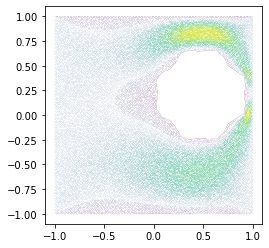

In [5]:
u, p = u_p.split()
fa.plot(u)

In [6]:
x0 = points_in_domain[120]

In [7]:
taylor = SecondOrderTaylorLookup(u_p, all_points, d = 3)

# Loss According to Jax Function

### Div U

0.25931156 5.863135e-07


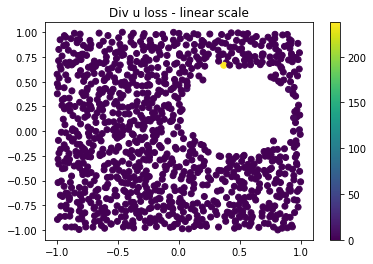

In [34]:
#jax_stress_loss = loss_domain_fn(taylor, points_in_domain, params) 
#jax_stress_loss_norm = np.linalg.norm(jax_stress_loss, axis = 1)
jax_divu_loss = loss_divu_fn(taylor, points_in_domain, params)

#print(np.mean(jax_stress_loss_norm, axis=0), np.median(jax_stress_loss_norm, axis=0))
print(np.mean(jax_divu_loss, axis=0), np.median(jax_divu_loss, axis=0))

plt.figure()
clrs = plt.scatter(points_in_domain[:,0], points_in_domain[:,1], c = np.array(jax_divu_loss))
plt.title('Div u loss - linear scale')
plt.colorbar(clrs)
plt.show()

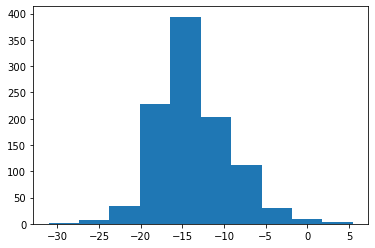

In [10]:
plt.figure()
plt.hist(np.log(jax_divu_loss))
plt.show()

### Stress

646.2983 0.012107045


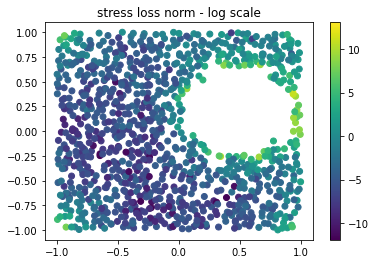

In [35]:
jax_stress_loss = loss_domain_fn(taylor, points_in_domain, params) 
jax_stress_loss_norm = np.linalg.norm(jax_stress_loss, axis = 1)
print(np.mean(jax_stress_loss_norm, axis=0), np.median(jax_stress_loss_norm, axis=0))
plt.figure()
clrs = plt.scatter(points_in_domain[:,0], points_in_domain[:,1], c = np.log(np.array(jax_stress_loss_norm)))
plt.title('stress loss norm - log scale')
plt.colorbar(clrs)
plt.show()

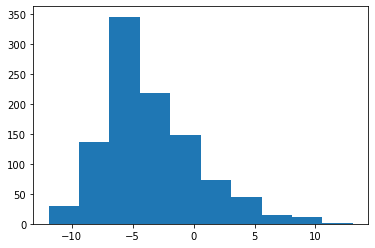

In [11]:
plt.figure()
plt.hist(np.log(jax_stress_loss_norm))
plt.show()

# Loss According to Fenics Function

In [12]:
u, p = fa.split(u_p)

### Div U

In [13]:
div_u_fenics = fa.div(u)

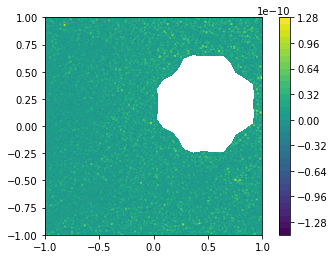

In [14]:
clrs = fa.plot(div_u_fenics)
plt.colorbar(clrs)

In [36]:
V = u_p.function_space()
mesh = V.mesh()
degree = V.ufl_element().degree()
W = fa.FunctionSpace(mesh, 'CG', degree)
div_u_fn = fa.project(fa.div(u), W, solver_type='mumps')

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_ef5bf05ec3ba797755a0b8c957bd6ac026a9dce7

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG2(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0279517 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_8c9c5d740e0b8f46aebb93ced5ecf171d3327be5

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_22]'
  Unique elements:           'CG2(?,?), Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Vecto
                             r<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Vecto
                             r<2 x CG1(?,?)>, Vector<2 x CG2(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 3
INFO:FFC:  quadrature_degree: 3
INFO

In [37]:
div_u_val = []
div_u_fn.set_allow_extrapolation(True)
for pt in all_points:
    div_u_val.append(div_u_fn(pt))
div_gradu_minus_p_fn.set_allow_extrapolation(False)

In [42]:
np.max(div_u_val)

125.85415798154082

(2218,)


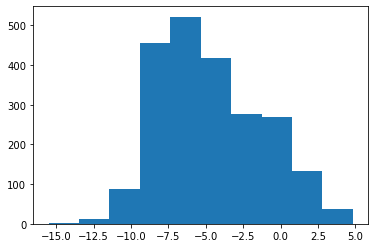

In [47]:
div_u_val = np.array(div_u_val)
print(div_u_val.shape)
 
plt.figure()
plt.hist(np.log(np.abs(div_u_val)))
plt.show()

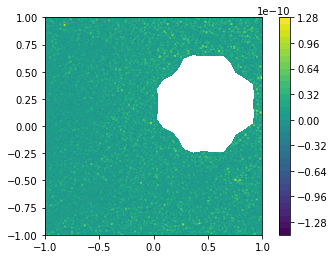

In [15]:
trace_jac_u_fenics = fa.tr(fa.grad(u))
clrs = fa.plot(trace_jac_u_fenics)
plt.colorbar(clrs)

In [16]:
fa.assemble(div_u_fenics*fa.dx)

1.7452765324117063e-14

In [17]:
jac_u = fa.project(fa.grad(u), 
                   fa.TensorFunctionSpace(u_p.function_space().mesh(), 'P', 2, (2, 2)), solver_type="mumps")

In [18]:
jac_u([0., 0.]).reshape(2,2)

array([[-6.93022657, -9.06447094],
       [ 7.25677765,  6.92904594]])

In [19]:
jac_u([-0.02, -0.02]).reshape(2,2)

array([[-6.03488871, -9.3605658 ],
       [ 5.16397328,  6.03294366]])

In [22]:
source_params[1]

DeviceArray(0.25975317, dtype=float32)

### Stress Loss

In [26]:
def strain_rate_fn(field):
    return (fa.grad(field) + fa.grad(field).T) / 2

-3.153884455320074

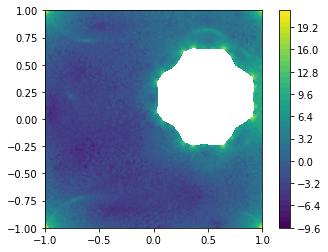

In [28]:
effective_sr = fa.sqrt(0.5 * fa.inner(strain_rate_fn(u), strain_rate_fn(u)))

mu_fn = float(source_params[0]) * effective_sr ** float(-source_params[1]) 

div_sigma = fa.div(2*mu_fn * strain_rate_fn(u) - p * fa.Identity(2))

lognorm = fa.ln(fa.inner(div_sigma, div_sigma))

clrs = fa.plot(lognorm)
plt.colorbar(clrs)

fa.assemble(lognorm*fa.dx)

In [30]:
V = u_p.function_space()
mesh = V.mesh()
degree = V.ufl_element().degree()
W = fa.VectorFunctionSpace(mesh, 'CG', degree, dim = 2)
div_gradu_minus_p_fn = fa.project(div_sigma, W, solver_type='mumps')

In [31]:
div_gradu_minus_p_val = []
div_gradu_minus_p_fn.set_allow_extrapolation(True)
for pt in all_points:
    div_gradu_minus_p_val.append(div_gradu_minus_p_fn(pt))
div_gradu_minus_p_fn.set_allow_extrapolation(False)

(2218, 2)


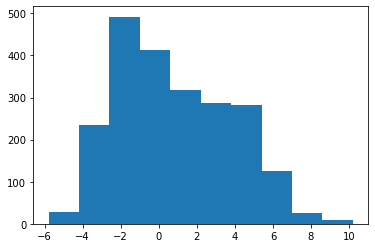

In [32]:
div_gradu_minus_p_val = np.array(div_gradu_minus_p_val)
print(div_gradu_minus_p_val.shape)
 
plt.figure()
plt.hist(np.log(np.linalg.norm(div_gradu_minus_p_val, axis = 1)))
plt.show()

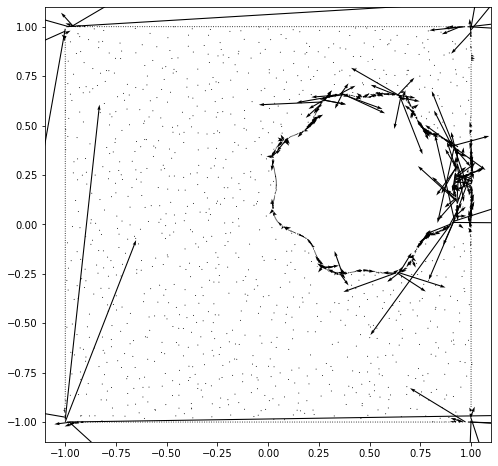

In [33]:
plt.figure(figsize = (8,8))
plt.quiver(all_points[:,0],all_points[:,1],div_gradu_minus_p_val[:,0],div_gradu_minus_p_val[:,1])